# Task definition
Implement LSTM Sentiment Tagger for imdb reviews dataset.

1. (5pt) Fill missing code below
    * 1pt implement vectorization
    * 2pt implement \_\_init\_\_ and forward methods of models
    * 2pt implement collate function
2. (4pt) Implement training loop, choose proper loss function, use clear ml for max points.
    * 2pts is a baseline for well written, working code
    * 2pts if clear ml used properly
3. (3pt) Train the models (find proper hyperparams). Make sure you are not overfitting or underfitting. Visualize training of your best model (plot training, and test loss/accuracy in time). Your model should reach at least 87% accuracy. For max points it should exceed 89%. 
    * 1pt for accuracy above 89%
    * 1pt for accuracy above 87%
    * 1pt for visualizations

Remarks:
* Use embeddings of size 50
* Use 0.5 threshold when computing accuracy.
* Use supplied dataset for training and evaluation.
* You do not have to use validation set.
* You should monitor overfitting during training.
* For max points use clear ml to store and manage logs from your experiments. 
* We encourage to use pytorch lightning library (Addtional point for using it - however the sum must not exceed 12)

[Clear ML documentation](https://clear.ml/docs/latest/docs/)

[Clear ML notebook exercise from bootcamp](https://colab.research.google.com/drive/1wtLb4gg8beLS7smcyJlOZppn6_rQvSxL?usp=sharing)

In [ ]:
!pip install clearml

import os
from collections import defaultdict

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torchtext
from clearml import Task

import torch
from torch import nn
from torch import optim

from torch.utils.data import Dataset, DataLoader
!pip install pytorch-lightning
import pytorch_lightning as pl

is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

In [ ]:
web_server = 'https://app.community.clear.ml'
api_server = 'https://api.community.clear.ml'
files_server = 'https://files.community.clear.ml'

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

task = Task.init(project_name='HW 3', task_name='PL + 89%')

ClearML Task: created new task id=36333fd2bcb54d918578aae0be3c1a22
2022-01-15 19:26:38,995 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.community.clear.ml/projects/027a9cb56ade405fafefda580f9f051e/experiments/36333fd2bcb54d918578aae0be3c1a22/output/log


In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1hK-3iiRPlbePb99Fe-34LJNZ5yB-nduq
!tar -xvzf imdb_dataset.gz
data = pd.read_csv("imdb_dataset.csv")

Downloading...
From: https://drive.google.com/uc?id=1hK-3iiRPlbePb99Fe-34LJNZ5yB-nduq
To: /content/imdb_dataset.gz
100% 77.0M/77.0M [00:00<00:00, 245MB/s]
imdb_dataset.csv


In [ ]:
PADDING_VALUE = 0

class NaiveVectorizer:
    def __init__(self, tokenized_data, **kwargs):
        tokenized_data = [seq.split() for seq in tokenized_data]
        # I use simple dictionary to vectorize words, there surely are
        # better implementations of this but not as clear to newbies;)
        self.wv = {}
        it = 1
        
        for seq in tokenized_data:
            for word in seq:
                # If word isn't found then put it in dictionary with value it+1.
                if not word in self.wv:
                    self.wv[word] = it
                    it += 1

    def vectorize(self, tokenized_seq):
        # There exists a possibility that len(tokens) != len(tokenized_seq)
        # because some words can be not in tokenized_data from __init__.
        tokens = []
        for idx, word in enumerate(tokenized_seq):
            if word in self.wv:
                tokens.append(self.wv[word])
        
        return torch.IntTensor(tokens)

class ImdbDataset(Dataset):
    SPLIT_TYPES = ["train", "test", "unsup"]

    def __init__(self, data, preprocess_fn, split="train"):
        super(ImdbDataset, self).__init__()
        if split not in self.SPLIT_TYPES:
            raise AttributeError(f"No such split type: {split}")

        self.split = split
        self.label = [i for i, c in enumerate(data.columns) if c == "sentiment"][0]
        self.data_col = [i for i, c in enumerate(data.columns) if c == "tokenized"][0]
        self.data = data[data["split"] == self.split]
        self.preprocess_fn = preprocess_fn

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.preprocess_fn(self.data.iloc[idx, self.data_col].split())
        label = self.data.iloc[idx, self.label]
        return (seq, label)

naive_vectorizer = NaiveVectorizer(data.loc[data["split"] == "train", "tokenized"])

def get_datasets():
    train_dataset = ImdbDataset(data, naive_vectorizer.vectorize)
    test_dataset = ImdbDataset(data, naive_vectorizer.vectorize, split="test")
        
    return train_dataset, test_dataset

def custom_collate_fn(pairs):
    labels = torch.tensor([data[1] for data in pairs]).float().to(device)
    sequences = [data[0] for data in pairs]
    lengths = torch.tensor([len(data[0]) for data in pairs])
    seqcs = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)

    return seqcs, lengths, labels

In [ ]:
class LSTMSentimentTagger(pl.LightningModule):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, dropout_percentage, classes, config):
        super(LSTMSentimentTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.config = config

        # vocab_size here is about 83k, to improve this implementation it would 
        # be wise to cut them to 10k most used words.
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(dropout_percentage)
        self.linear = nn.Linear(self.hidden_dim, classes)

    def forward(self, sentence, lengths):
        batch_size = sentence.shape[0]

        embeds = self.dropout(self.embedding(sentence)) 
        # embeds.shape = (Batch_size, max seq len, embedding dim)

        packed = torch.nn.utils.rnn.pack_padded_sequence(embeds, lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstms, _ = self.lstm(packed)
        unpacked, _ = torch.nn.utils.rnn.pad_packed_sequence(lstms, batch_first=True) 
        # unpacked.shape = (Batch_size, max seq len, hidden dim)

        lstm_out = unpacked.contiguous().view(-1, self.hidden_dim) 
        # lstm_out.shape = (Batch_size * max seq len, hidden dim)

        out = self.dropout(lstm_out)
        out = self.linear(out) 
        # out.shape = (Batch_size * max seq len, 1)
        out = out.view(batch_size, -1) 
        # out.shape = (Batch_size, max seq len)
        
        # Get values at the last words of sequences 
        # (it is different than last element of sequences because of padding).
        out = torch.stack([r[lengths[idx] - 1] for idx, r in enumerate(out)])
        # out.shape = (Batch_size, 1)

        # Here I am not using sigmoid because I will be using BCEWithLogitsLoss().

        return out

    def configure_optimizers(self):
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
        return optimizer

    def training_step(self, train_batch, batch_idx):
        seqcs, lengths, labels = train_batch
        output = self(seqcs, lengths)
        loss = nn.BCEWithLogitsLoss()(output, labels)
        self.log('loss', loss, on_epoch=True)
        return loss

    def test_step(self, val_batch, batch_idx):
        seqcs, lengths, labels = val_batch
        output = self(seqcs, lengths)
        loss = nn.BCEWithLogitsLoss()(output, labels)
        accuracy =  torch.sum(torch.round(torch.sigmoid(output)) == labels) / len(labels)
        output = dict({
            'loss': loss,
            'acc': torch.tensor(accuracy),
        })
        self.log('out', output)
        return output

# Trainig loop and visualizations


In [ ]:
config = {
    'batch_size': 32,
    'epochs': 12,
    'lr': 0.001,
    'hidden_dim': 196,
    'dropout': 0.5
}

task.connect(config)
logger = task.get_logger()

train_dataset, test_dataset = get_datasets()
train_loader = DataLoader(train_dataset, 
                          shuffle=True, # Shuffling because first huge segment of data is of sentiment 1.
                          batch_size=config['batch_size'], 
                          collate_fn=custom_collate_fn)

test_loader = DataLoader(test_dataset, 
                         batch_size=config['batch_size'], 
                         collate_fn=custom_collate_fn)

In [ ]:
model = LSTMSentimentTagger(embedding_dim = 50, 
                            hidden_dim=config['hidden_dim'], 
                            vocab_size=len(naive_vectorizer.wv)+1, #about 83k
                            dropout_percentage=config['dropout'], 
                            classes=1, 
                            config=config).to(device)

# max_epochs is 1 because I want to use Trainer.fit and after every fit make
# some tests, it would be less possible with here max_epochs 
# set to config['epochs']. 
# enable_checkpointing=False because it enables me to call Trainer.fit without
# checkpointing to last fit and actually progress in learning NN.
trainer = pl.Trainer(gpus=1, max_epochs=1, enable_checkpointing=False)

# Lists for plots
test_loss = []
test_acc = []
train_loss = []
train_acc = []

for epoch in range(config['epochs']):
    print("==================== EPOCH NR", epoch, "=========================")
    trainer.fit(model, train_loader)

    train_res = trainer.test(model, train_loader)
    train_loss.append((train_res[0]['out'])['loss'].item())
    train_acc.append((train_res[0]['out'])['acc'].item())

    test_res = trainer.test(model, test_loader)
    test_loss.append((test_res[0]['out'])['loss'].item())
    test_acc.append((test_res[0]['out'])['acc'].item())

    logger.report_scalar(title='Accuracy', series='Train', iteration=epoch, value=train_acc[-1])
    logger.report_scalar(title='Accuracy', series='Test', iteration=epoch, value=test_acc[-1])
    logger.report_scalar(title='Loss', series='Train', iteration=epoch, value=train_loss[-1])
    logger.report_scalar(title='Loss', series='Test', iteration=epoch, value=test_loss[-1])

task.upload_artifact(name='model_dict', artifact_object=model.state_dict())

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/lightning_logs

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 4.4 M 
1 | lstm      | LSTM      | 194 K 
2 | dropout   | Dropout   | 0     
3 | linear    | Linear    | 197   
----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.184    Total estimated model params size (MB)


==================== EPOCH NR 0 =========================


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:658: UserWarning:

Your `test_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.



Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.6166, device='cuda:0'),
         'loss': tensor(0.6511, device='cuda:0')}}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 4.4 M 
1 | lstm      | LSTM      | 194 K 
2 | dropout   | Dropout   | 0     
3 | linear    | Linear    | 197   
----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.184    Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.6041, device='cuda:0'),
         'loss': tensor(0.6578, device='cuda:0')}}
--------------------------------------------------------------------------------
==================== EPOCH NR 1 =========================


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.7024, device='cuda:0'),
         'loss': tensor(0.5776, device='cuda:0')}}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 4.4 M 
1 | lstm      | LSTM      | 194 K 
2 | dropout   | Dropout   | 0     
3 | linear    | Linear    | 197   
----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.184    Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.6887, device='cuda:0'),
         'loss': tensor(0.5965, device='cuda:0')}}
--------------------------------------------------------------------------------
==================== EPOCH NR 2 =========================


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.7138, device='cuda:0'),
         'loss': tensor(0.5406, device='cuda:0')}}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 4.4 M 
1 | lstm      | LSTM      | 194 K 
2 | dropout   | Dropout   | 0     
3 | linear    | Linear    | 197   
----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.184    Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.6972, device='cuda:0'),
         'loss': tensor(0.5645, device='cuda:0')}}
--------------------------------------------------------------------------------
==================== EPOCH NR 3 =========================


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.8112, device='cuda:0'),
         'loss': tensor(0.4353, device='cuda:0')}}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 4.4 M 
1 | lstm      | LSTM      | 194 K 
2 | dropout   | Dropout   | 0     
3 | linear    | Linear    | 197   
----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.184    Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.7833, device='cuda:0'),
         'loss': tensor(0.4737, device='cuda:0')}}
--------------------------------------------------------------------------------
==================== EPOCH NR 4 =========================


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.8502, device='cuda:0'),
         'loss': tensor(0.3562, device='cuda:0')}}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 4.4 M 
1 | lstm      | LSTM      | 194 K 
2 | dropout   | Dropout   | 0     
3 | linear    | Linear    | 197   
----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.184    Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.8192, device='cuda:0'),
         'loss': tensor(0.4059, device='cuda:0')}}
--------------------------------------------------------------------------------
==================== EPOCH NR 5 =========================


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.8966, device='cuda:0'),
         'loss': tensor(0.2596, device='cuda:0')}}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 4.4 M 
1 | lstm      | LSTM      | 194 K 
2 | dropout   | Dropout   | 0     
3 | linear    | Linear    | 197   
----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.184    Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.8614, device='cuda:0'),
         'loss': tensor(0.3238, device='cuda:0')}}
--------------------------------------------------------------------------------
==================== EPOCH NR 6 =========================


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.9172, device='cuda:0'),
         'loss': tensor(0.2124, device='cuda:0')}}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 4.4 M 
1 | lstm      | LSTM      | 194 K 
2 | dropout   | Dropout   | 0     
3 | linear    | Linear    | 197   
----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.184    Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.8788, device='cuda:0'),
         'loss': tensor(0.2863, device='cuda:0')}}
--------------------------------------------------------------------------------
==================== EPOCH NR 7 =========================


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.9310, device='cuda:0'),
         'loss': tensor(0.1866, device='cuda:0')}}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 4.4 M 
1 | lstm      | LSTM      | 194 K 
2 | dropout   | Dropout   | 0     
3 | linear    | Linear    | 197   
----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.184    Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.8877, device='cuda:0'),
         'loss': tensor(0.2695, device='cuda:0')}}
--------------------------------------------------------------------------------
==================== EPOCH NR 8 =========================


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.9398, device='cuda:0'),
         'loss': tensor(0.1621, device='cuda:0')}}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 4.4 M 
1 | lstm      | LSTM      | 194 K 
2 | dropout   | Dropout   | 0     
3 | linear    | Linear    | 197   
----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.184    Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.8909, device='cuda:0'),
         'loss': tensor(0.2590, device='cuda:0')}}
--------------------------------------------------------------------------------
==================== EPOCH NR 9 =========================


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.9464, device='cuda:0'),
         'loss': tensor(0.1447, device='cuda:0')}}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 4.4 M 
1 | lstm      | LSTM      | 194 K 
2 | dropout   | Dropout   | 0     
3 | linear    | Linear    | 197   
----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.184    Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.8982, device='cuda:0'),
         'loss': tensor(0.2519, device='cuda:0')}}
--------------------------------------------------------------------------------
==================== EPOCH NR 10 =========================


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.9440, device='cuda:0'),
         'loss': tensor(0.1439, device='cuda:0')}}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | embedding | Embedding | 4.4 M 
1 | lstm      | LSTM      | 194 K 
2 | dropout   | Dropout   | 0     
3 | linear    | Linear    | 197   
----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.184    Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.8951, device='cuda:0'),
         'loss': tensor(0.2504, device='cuda:0')}}
--------------------------------------------------------------------------------
==================== EPOCH NR 11 =========================


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.9595, device='cuda:0'),
         'loss': tensor(0.1174, device='cuda:0')}}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'out': {'acc': tensor(0.9022, device='cuda:0'),
         'loss': tensor(0.2411, device='cuda:0')}}
--------------------------------------------------------------------------------
2022-01-15 19:45:38,636 - clearml - WARNING - JSON serialization of artifact 'model_dict' failed, reverting to pickle


True

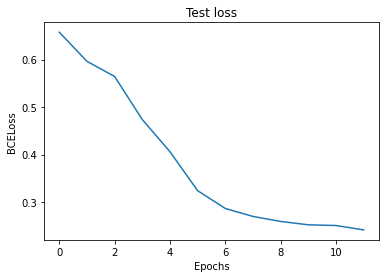

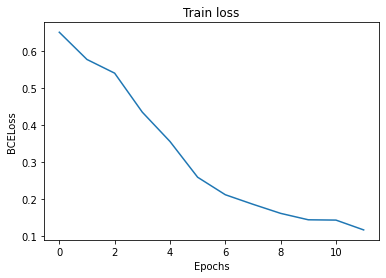

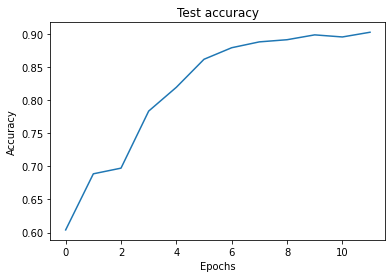

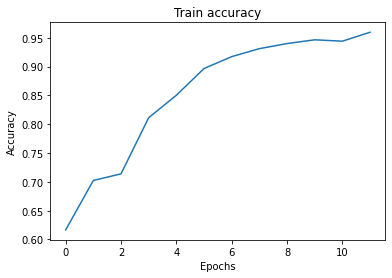

In [ ]:
import matplotlib.pyplot as plt

range_epochs = range(config['epochs'])
plt.plot(range_epochs, test_loss)
plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('BCELoss')
plt.show()

plt.plot(range_epochs, train_loss)
plt.title('Train loss')
plt.xlabel('Epochs')
plt.ylabel('BCELoss')
plt.show()

plt.plot(range_epochs, test_acc)
plt.title('Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(range_epochs, train_acc)
plt.title('Train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
task.close()